In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from math import exp, sqrt, pi
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

In [2]:
epochs = 10
device = torch.device("cpu")

eps = 0.1

learning_rate = 1e-3
batchflag = True
batchsize = 128

start = 0.
end = 1.
x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))

def actual_soln(eps):
    p = 1 - np.exp(-1/eps);q = 1 + np.exp(-1/eps);d = 1/(q - 2*eps*p)
    return (np.sin(np.pi*x) + (eps*np.pi/p)*(np.exp(-x/eps) + np.exp((x-1)/eps) - q) ) * (2*y*(1 - y**2) + eps * ( p*d*(1-2*y) - 3*q/p + (3/p - d)*np.exp(-y/eps) + (3/p + d)*np.exp((y-1)/eps)))


In [3]:
def plot_graph(soln,soln_name):
    x = np.linspace(start,end,100);y = np.linspace(start,end,100)
    x,y = np.meshgrid(x,y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,y,soln.reshape(100,100))
    plt.title(soln_name)
    plt.show()

def plot_graphs(soln1,soln2,soln_name):
    x = np.linspace(start,end,100);y = np.linspace(start,end,100)
    x,y = np.meshgrid(x,y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,y,soln1.reshape(100,100))
    plt.title(soln_name)
    plt.show()

class Swish(nn.Module):
	def __init__(self, inplace=True):
		super(Swish, self).__init__()
		self.inplace = inplace

	def forward(self, x):
		if self.inplace:
			x.mul_(torch.sigmoid(x))
			return x
		else:
			return x * torch.sigmoid(x)
	

class FBPINN(nn.Module):
	hid_dim = 128
	input_dim = 2 
	def __init__(self):
		super(FBPINN, self).__init__()
		self.tanh = nn.Tanh()
		self.lin0 = nn.Linear(self.input_dim,self.hid_dim)
		self.lin = nn.Linear(self.hid_dim,self.hid_dim)
		self.lin1 = nn.Linear(self.hid_dim,1)
		self.swish = Swish()


	def forward(self,x):		
		tanh1 = self.tanh(x)
		tanh2 = self.tanh(1 - x)
		tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))*(tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
		tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))*(tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
		x = self.lin0(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin1(x)
		out = x*tanh11*tanh22
		return out

In [4]:

def train(device,net,x,y,eps,learning_rate,epochs,batch_flag,batch_size):

	xnet = torch.Tensor(x)
	ynet = torch.Tensor(y) 
	
	if(batch_flag):
		dataset = TensorDataset(xnet,ynet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )
		#print(len(dataloader))
	
	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)
		U = U.view(len(U),-1)
		
		p = 1 - np.exp(-1/eps);q = 1 + np.exp(-1/eps);d = 1/(q - 2*eps*p)
		
		soln = (torch.sin(np.pi*xnet) + (eps*np.pi/p)*(torch.exp(-xnet/eps) + torch.exp((xnet-1)/eps) - q) ) * (2*ynet*(1 - ynet*ynet) + eps * ( p*d*(1-2*ynet) - 3*q/p + (3/p - d)*torch.exp(-ynet/eps) + (3/p + d)*torch.exp((ynet-1)/eps)))
		
		soln_x = torch.autograd.grad(soln,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xx = torch.autograd.grad(soln_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxx = torch.autograd.grad(soln_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxxx = torch.autograd.grad(soln_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_y = torch.autograd.grad(soln,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yy = torch.autograd.grad(soln_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyy = torch.autograd.grad(soln_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyyy = torch.autograd.grad(soln_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxy = torch.autograd.grad(soln_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxyy = torch.autograd.grad(soln_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		
		f = (eps**2)*(soln_xxxx + soln_yyyy + 2*soln_xxyy) - (soln_xx + soln_yy)
		
		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	losses = []
	tic = time.time()

	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 30:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,y_in) in enumerate(dataloader):

				net.zero_grad()
				loss = Loss_criterion(x_in,y_in)
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 == 0:
					print('Train Epoch: {} \tLoss: {:.20f}'.format(epoch, loss.item()))

			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.20f}\n'.format(
				epoch, actual_loss))
			if epoch % 1 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append([loss.item(),actual_loss])

	else:
		for epoch in range(epochs):
			if epoch == 50:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
		
			net.zero_grad()
			loss = Loss_criterion(xnet,ynet)
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.20f}\n'.format(
				epoch, actual_loss))
			if epoch % 5 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append([loss.item(),actual_loss])

	toc = time.time()
	elapseTime = toc - tic
	print ("Time elapsed = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output,net 

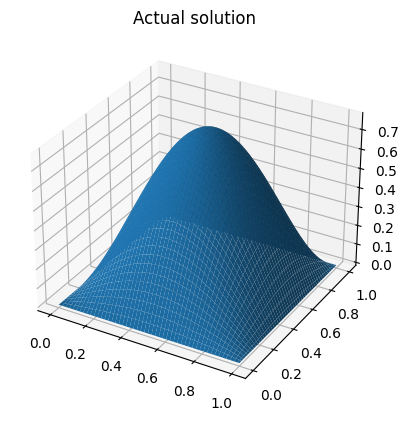

In [5]:
plot_graph(actual_soln(0.0001),'Actual solution')



1


Train Epoch: 0 	Loss: 4.51947927474975585938
Train Epoch: 0 	Loss: 0.37374705076217651367
Train Epoch: 0 	Loss: 0.07087901979684829712
Train Epoch: 0 	Loss: 0.02129225246608257294

After Epoch 0, 	 Actual solution loss: 0.00000000002829334050



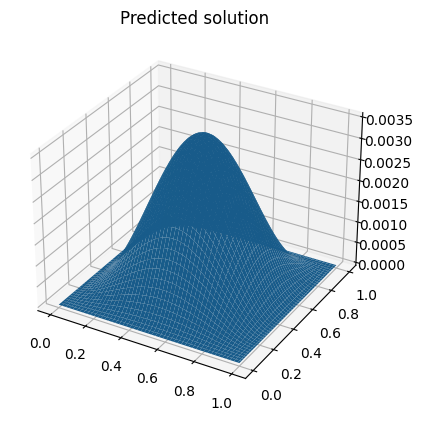

Train Epoch: 1 	Loss: 0.00770232127979397774
Train Epoch: 1 	Loss: 0.00652095209807157516
Train Epoch: 1 	Loss: 0.00392759125679731369
Train Epoch: 1 	Loss: 0.00260829110629856586

After Epoch 1, 	 Actual solution loss: 0.00000000007475764311



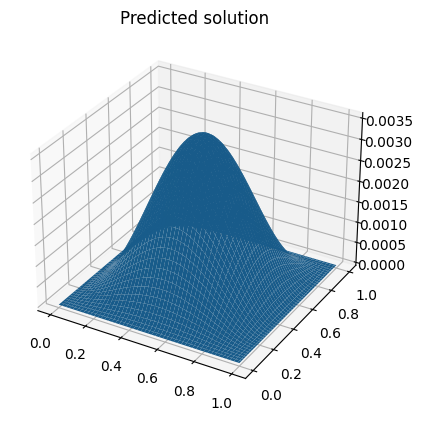

Train Epoch: 2 	Loss: 0.00240807351656258106
Train Epoch: 2 	Loss: 0.00126889592502266169
Train Epoch: 2 	Loss: 0.00158266292419284582
Train Epoch: 2 	Loss: 0.00209420989267528057

After Epoch 2, 	 Actual solution loss: 0.00000000000452203742



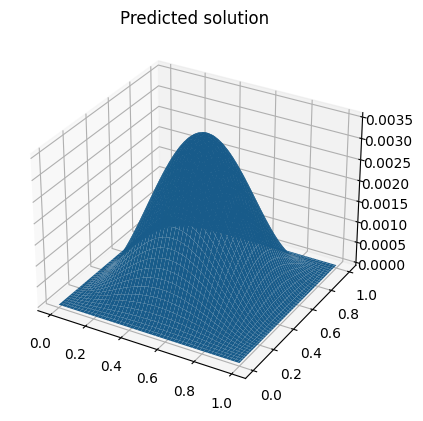

Train Epoch: 3 	Loss: 0.00084084045374765992
Train Epoch: 3 	Loss: 0.00094793038442730904
Train Epoch: 3 	Loss: 0.00058154552243649960
Train Epoch: 3 	Loss: 0.00062748423079028726

After Epoch 3, 	 Actual solution loss: 0.00000000000116200108



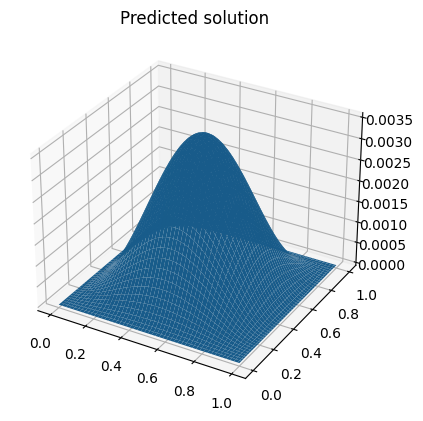

Train Epoch: 4 	Loss: 0.00062792556127533317
Train Epoch: 4 	Loss: 0.00056290201609954238
Train Epoch: 4 	Loss: 0.00078268983634188771
Train Epoch: 4 	Loss: 0.00070416921516880393

After Epoch 4, 	 Actual solution loss: 0.00000000000812529826



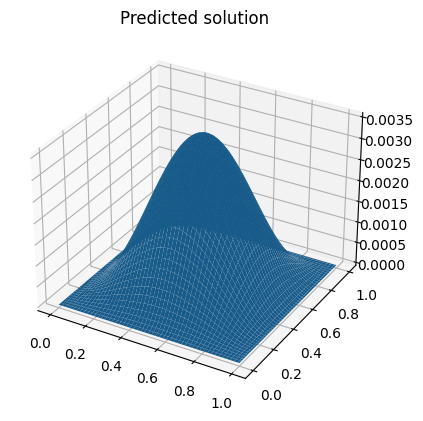

Train Epoch: 5 	Loss: 0.00040713261114433408
Train Epoch: 5 	Loss: 0.00063359586056321859
Train Epoch: 5 	Loss: 0.00049162941286340356
Train Epoch: 5 	Loss: 0.00049859948921948671

After Epoch 5, 	 Actual solution loss: 0.00000000000136190253



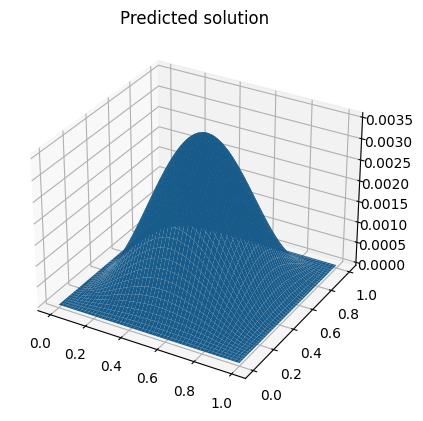

Train Epoch: 6 	Loss: 0.00049279280938208103
Train Epoch: 6 	Loss: 0.00050667126197367907
Train Epoch: 6 	Loss: 0.00019455233996268362
Train Epoch: 6 	Loss: 0.00024327512073796242

After Epoch 6, 	 Actual solution loss: 0.00000000004005106300



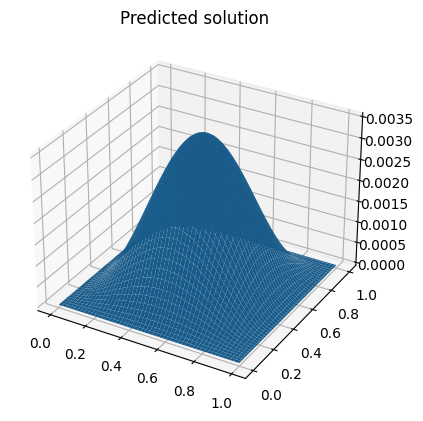

Train Epoch: 7 	Loss: 0.00067717826459556818
Train Epoch: 7 	Loss: 0.00127709505613893270
Train Epoch: 7 	Loss: 0.00054748909315094352
Train Epoch: 7 	Loss: 0.00164118513930588961

After Epoch 7, 	 Actual solution loss: 0.00000000011135486143



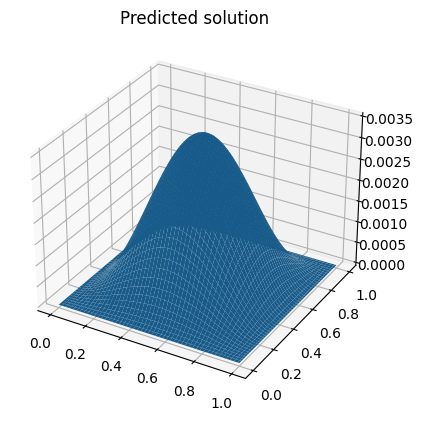

Train Epoch: 8 	Loss: 0.00066779169719666243
Train Epoch: 8 	Loss: 0.00047351035755127668
Train Epoch: 8 	Loss: 0.00019012928532902151
Train Epoch: 8 	Loss: 0.00016865396173670888

After Epoch 8, 	 Actual solution loss: 0.00000000000057276399



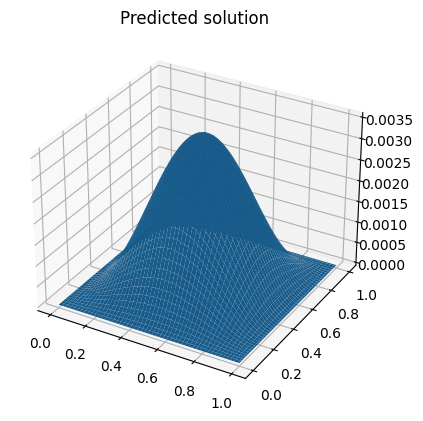

Train Epoch: 9 	Loss: 0.00015032470400910825
Train Epoch: 9 	Loss: 0.00072355201700702310
Train Epoch: 9 	Loss: 0.00333080487325787544
Train Epoch: 9 	Loss: 0.00030368924490176141

After Epoch 9, 	 Actual solution loss: 0.00000000001193710108



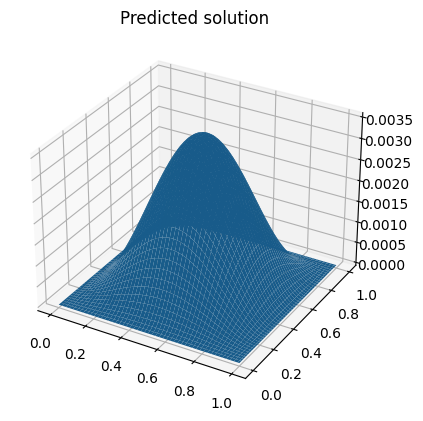

Time elapsed =  461.7244303226471


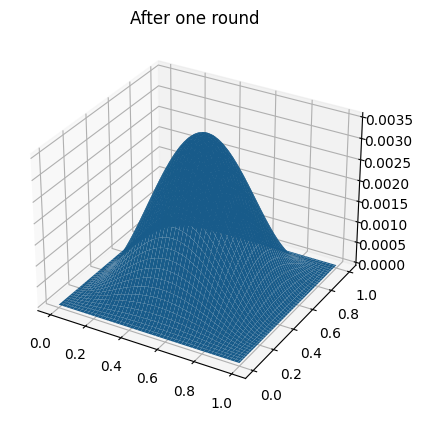



0.1


Train Epoch: 0 	Loss: 25.32404518127441406250
Train Epoch: 0 	Loss: 25.31831169128417968750
Train Epoch: 0 	Loss: 22.92364501953125000000
Train Epoch: 0 	Loss: 16.27513313293457031250

After Epoch 0, 	 Actual solution loss: 0.00481180368384434565



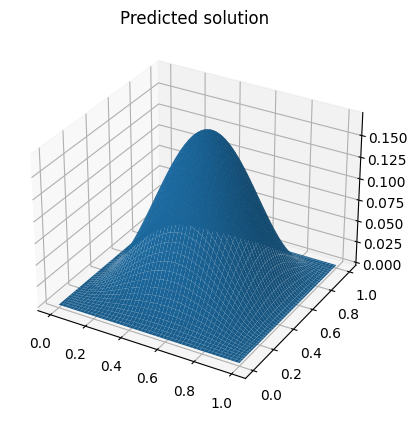

Train Epoch: 1 	Loss: 15.51045799255371093750
Train Epoch: 1 	Loss: 14.83026504516601562500
Train Epoch: 1 	Loss: 11.97887802124023437500
Train Epoch: 1 	Loss: 9.45125770568847656250

After Epoch 1, 	 Actual solution loss: 0.00115447406700340603



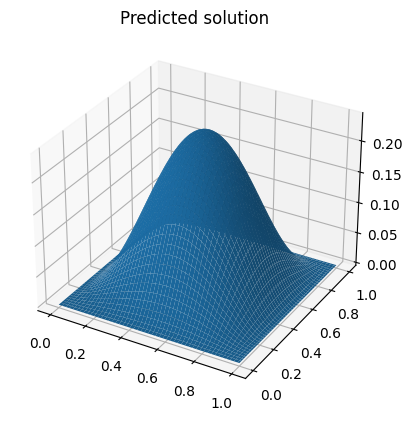

Train Epoch: 2 	Loss: 6.99411535263061523438
Train Epoch: 2 	Loss: 2.76838350296020507812
Train Epoch: 2 	Loss: 1.37495076656341552734
Train Epoch: 2 	Loss: 0.52808791399002075195

After Epoch 2, 	 Actual solution loss: 0.00003167696524191547



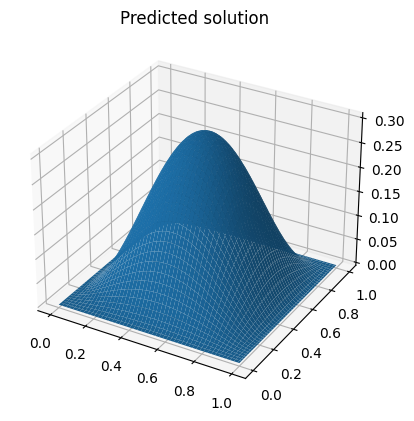

Train Epoch: 3 	Loss: 0.23258483409881591797
Train Epoch: 3 	Loss: 0.11549092829227447510
Train Epoch: 3 	Loss: 0.11666899919509887695
Train Epoch: 3 	Loss: 0.07883702963590621948

After Epoch 3, 	 Actual solution loss: 0.00000699841333079417



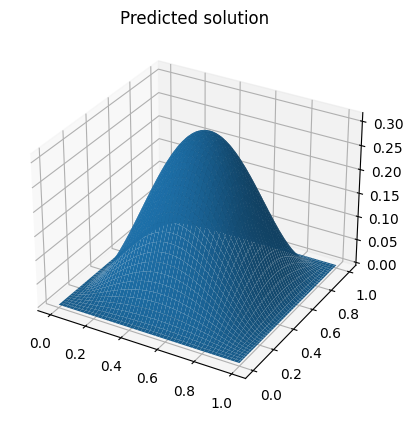

Train Epoch: 4 	Loss: 0.07441090047359466553
Train Epoch: 4 	Loss: 0.05697986111044883728
Train Epoch: 4 	Loss: 0.03963423520326614380
Train Epoch: 4 	Loss: 0.02603051811456680298

After Epoch 4, 	 Actual solution loss: 0.00000115543043398424



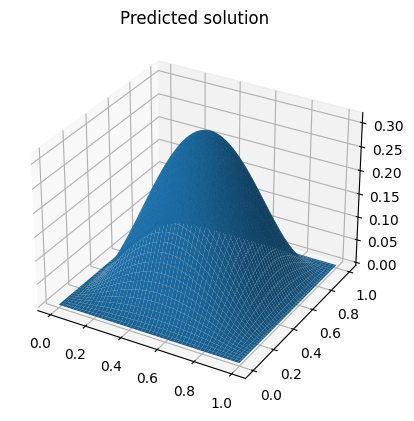

Train Epoch: 5 	Loss: 0.03200672194361686707
Train Epoch: 5 	Loss: 0.01316133234649896622
Train Epoch: 5 	Loss: 0.01336147636175155640
Train Epoch: 5 	Loss: 0.02879017032682895660

After Epoch 5, 	 Actual solution loss: 0.00000003303365417397



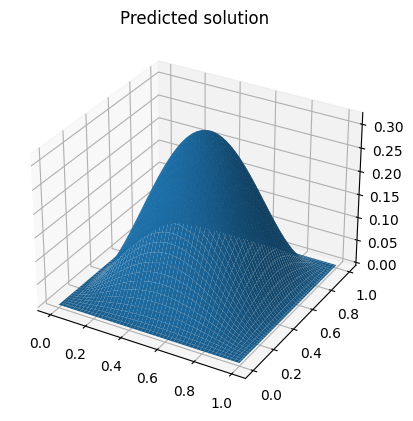

Train Epoch: 6 	Loss: 0.01114186458289623260
Train Epoch: 6 	Loss: 0.01661808229982852936
Train Epoch: 6 	Loss: 0.00929410848766565323
Train Epoch: 6 	Loss: 0.00797828938812017441

After Epoch 6, 	 Actual solution loss: 0.00000001202432980359



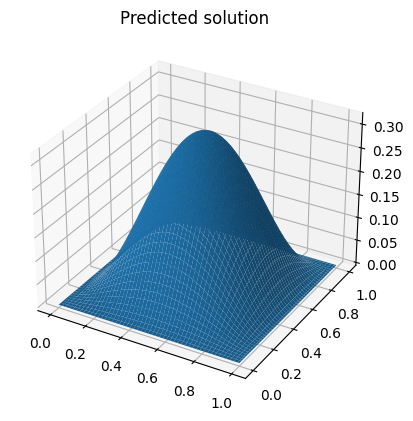

Train Epoch: 7 	Loss: 0.01346575375646352768
Train Epoch: 7 	Loss: 0.00791959837079048157
Train Epoch: 7 	Loss: 0.00669186608865857124
Train Epoch: 7 	Loss: 0.00500139733776450157

After Epoch 7, 	 Actual solution loss: 0.00000016284771176322



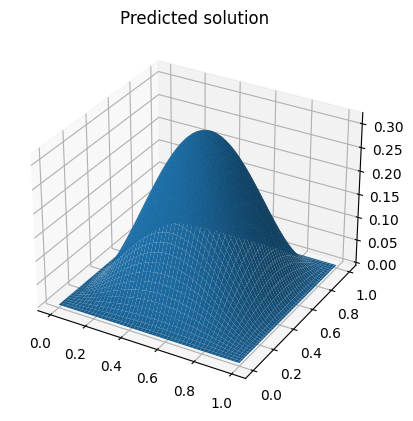

Train Epoch: 8 	Loss: 0.00298246345482766628
Train Epoch: 8 	Loss: 0.01191427465528249741
Train Epoch: 8 	Loss: 0.00461617857217788696
Train Epoch: 8 	Loss: 0.00934270955622196198

After Epoch 8, 	 Actual solution loss: 0.00000033983716653829



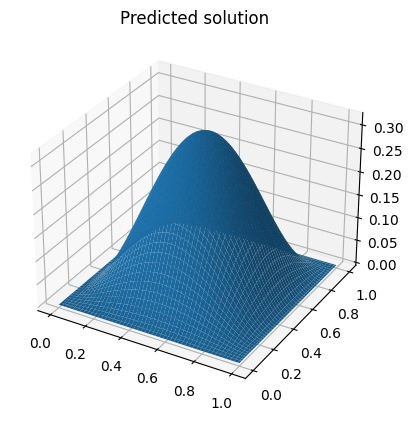

Train Epoch: 9 	Loss: 0.00601167790591716766
Train Epoch: 9 	Loss: 0.00330585287883877754
Train Epoch: 9 	Loss: 0.00831714551895856857
Train Epoch: 9 	Loss: 0.00363432080484926701

After Epoch 9, 	 Actual solution loss: 0.00000008734568243995



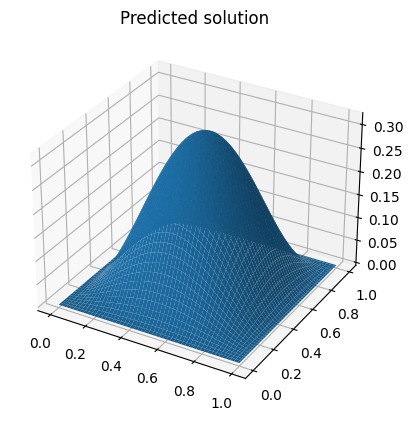

Time elapsed =  288.48755955696106


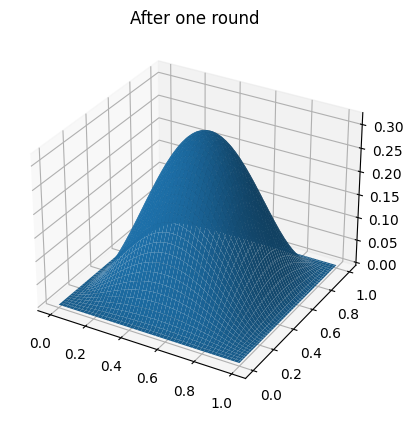



0.01


Train Epoch: 0 	Loss: 66.62918090820312500000
Train Epoch: 0 	Loss: 52.89492034912109375000
Train Epoch: 0 	Loss: 55.67335128784179687500
Train Epoch: 0 	Loss: 50.73397827148437500000

After Epoch 0, 	 Actual solution loss: 0.07857443227135653407



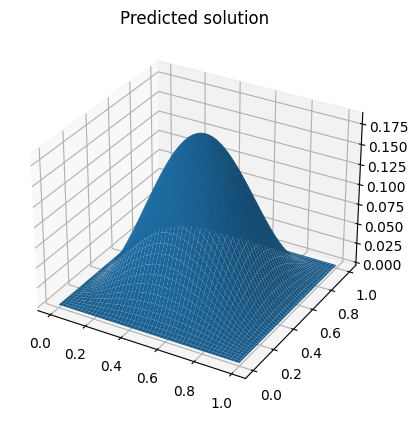

Train Epoch: 1 	Loss: 56.43801116943359375000
Train Epoch: 1 	Loss: 53.31945037841796875000
Train Epoch: 1 	Loss: 66.59758758544921875000
Train Epoch: 1 	Loss: 54.11091995239257812500

After Epoch 1, 	 Actual solution loss: 0.08317007708031647073



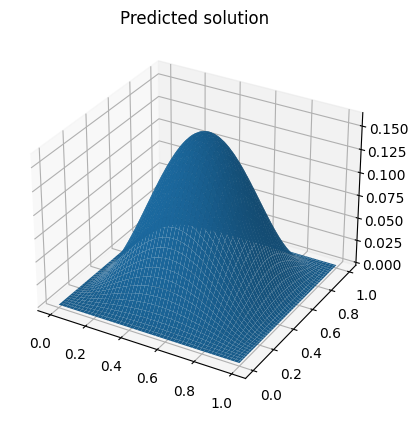

Train Epoch: 2 	Loss: 53.89209747314453125000
Train Epoch: 2 	Loss: 63.39726257324218750000
Train Epoch: 2 	Loss: 51.75424957275390625000
Train Epoch: 2 	Loss: 54.77845001220703125000

After Epoch 2, 	 Actual solution loss: 0.07905795794539990928



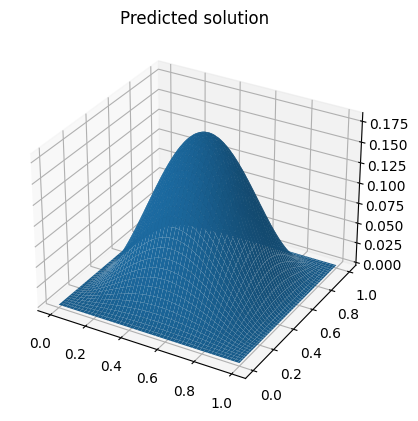

Train Epoch: 3 	Loss: 58.34423828125000000000
Train Epoch: 3 	Loss: 55.10737609863281250000
Train Epoch: 3 	Loss: 48.83217239379882812500
Train Epoch: 3 	Loss: 48.79306793212890625000

After Epoch 3, 	 Actual solution loss: 0.08552692094711673854



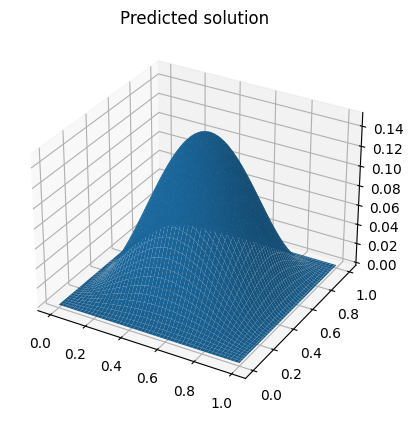

Train Epoch: 4 	Loss: 54.27231216430664062500
Train Epoch: 4 	Loss: 64.84097290039062500000
Train Epoch: 4 	Loss: 50.34983062744140625000
Train Epoch: 4 	Loss: 49.94353485107421875000

After Epoch 4, 	 Actual solution loss: 0.07905223158757476720



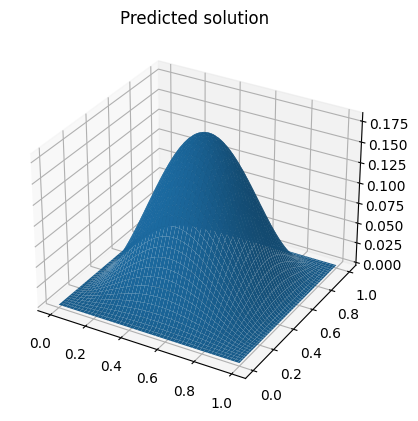

Train Epoch: 5 	Loss: 55.19110107421875000000
Train Epoch: 5 	Loss: 56.78766632080078125000
Train Epoch: 5 	Loss: 55.72115325927734375000
Train Epoch: 5 	Loss: 54.59529495239257812500

After Epoch 5, 	 Actual solution loss: 0.08433020881069780428



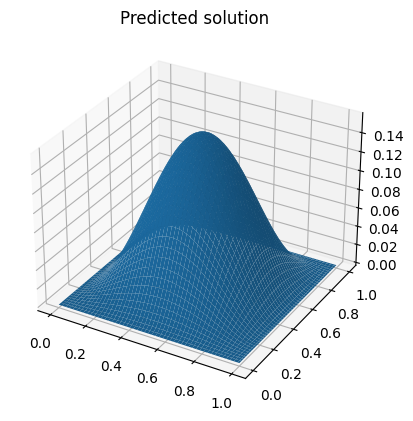

Train Epoch: 6 	Loss: 57.29530334472656250000
Train Epoch: 6 	Loss: 60.95735168457031250000
Train Epoch: 6 	Loss: 52.71659469604492187500


KeyboardInterrupt: 

In [6]:
net = FBPINN()#.to(device)
	
def init_normal(m):
	if type(m) == nn.Linear:
		nn.init.kaiming_normal_(m.weight)

net.apply(init_normal)

for eps in [1,0.1,0.01,0.001,0.0001,0.00001]:
	print('\n\n  Epsilon : {}\n\n'.format(eps))
	output,net = train(device,net,x,y,eps,learning_rate,epochs,batchflag,batchsize)
	plot_graph(output.detach().numpy(),"After one round")